# LINMA2222 - Stochastic Optimal Control & Reinforcement Learning
## Portfolio optimal strategy
---

### Imports

In [191]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)  # For reproducibility

### Constants

In [192]:
THETA = 0.5
W_A = 0.1
W_U = 0.2
SIGMA_A = 0.018
SIGMA_P = 0.02
BETA_U = -0.048
GAMMA_U = 0.06

### Plot functions

In [193]:

from tqdm import tqdm
def generate_trajectories(policy, x0=(0, 0, 0), T=1000, N=1, xi_a=None, xi_p=None, show_progress=False):
    """Generate the state variables x_t and actions u_t for t=0,...,T
       using the given policy.

    Args:
        policy: a function that takes in the current state x_t and returns an action u_t
        x0 (ndarray): initial state. Defaults to 0.
        T (int): number of time steps. Defaults to 1000.
    """
    x = np.zeros((T+1, 3, N))  # State variables: q_t, za_t, zu_t
    u = np.zeros((T, N))       # Actions
    x[0] = np.array(x0).reshape(3, 1)
    if xi_a is None:  xi_a = rng.normal(0, 1, size=(T, N))
    if xi_p is None:  xi_p = rng.normal(0, 1, size=(T, N))

    # tqdm that goes away when done : 
    for t in range(T) if not show_progress else tqdm(range(T), desc="Generating trajectories"):
        u[t] = policy(x[t])
        x[t+1, 0] = x[t, 0] + u[t] # q_t
        x[t+1, 1] = (1 - W_A) * x[t, 1] + W_A * SIGMA_A * xi_a[t]  # za_t
        x[t+1, 2] = (1 - W_U) * x[t, 2] + W_U * BETA_U * u[t]  # zu_t

    return x, u, xi_p


def g(q, za, zu , u, xi_p=None):
    """Compute the gross stage reward at each time given state x and action u."""
    # q, za, zu = x[:, 0], x[:, 1], x[:, 2]
    if xi_p is None:
        xi_p = rng.normal(0, 1, size=q.shape[0])

    # Formula found by replacing p_t+1 and p_t by their expressions in the given model (see Question 2.3)
    return 1000 * q * (za + zu + (GAMMA_U * u) + (SIGMA_P * xi_p)) + THETA * u * (za + zu + (SIGMA_P * xi_p))


def c(g):   
    """Compute the net stage reward given gross stage reward g_t for each time t"""
    return np.maximum(g - (np.pow(g, 2) / 2), 1 - np.exp(-g))

def reward(x, u, xi_p, t):
    """Compute all the rewards over the trajectory given states x and actions u from time 0 to t."""
    """returns an array of shape (t,N)"""
    g_t = g(x[:t, 0], x[:t, 1], x[:t, 2], u[:t], xi_p=xi_p[:t])
    c_t = c(g_t)
    return c_t

def average_reward(x, u, xi_p, t):
    return np.nanmean(reward(x, u, xi_p, t))


def plot_trajectories(x, u, xi_p, filename=None, mean=False, variance=False, T=None, policy_name=""):
    """Plot the trajectories of the state variables and actions over time in a 2x2 grid
       and add an additional plot for the average reward as a function of time."""
    print(f"Plotting {filename} : reward = {average_reward(x, u, xi_p, x.shape[0]-1)}")

    if T is None:
        T = x.shape[0] - 1
    print(f"Plotting {filename} : reward = {average_reward(x, u, xi_p, T)}")
    
    time = np.arange(T+1)
    # plt.title(f"Trajectories of states and actions over time\nPolicy: {policy_name}")
    # plt.title(policy_name)
    # fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # add the title above the 2x2 grid
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"Trajectories of states and actions over time\nPolicy: {policy_name}", fontsize=16)


    axs[0, 0].plot(time, x[:, 0], label=r'$q_t$', color='blue')
    if mean:
        axs[0, 0].hlines(np.mean(x[:, 0]), 0, T, colors='darkblue', linestyles='dashed', label='Mean')
    if variance:
        axs[0, 0].fill_between(time, np.mean(x[:, 0]) - np.std(x[:, 0]), np.mean(x[:, 0]) + np.std(x[:, 0]), color='cyan', alpha=0.3, label='Variance')
    axs[0, 0].set_title(r'$q_t$')
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_ylabel(r'$q_t$')
    axs[0, 0].grid()
    axs[0, 0].legend()

    axs[0, 1].plot(time, x[:, 1], label=r'$z^{a}_{t}$', color='orange')
    if mean:
        axs[0, 1].hlines(np.mean(x[:, 1]), 0, T, colors='darkorange', linestyles='dashed', label='Mean')
    if variance:
        axs[0, 1].fill_between(time, np.mean(x[:, 1]) - np.std(x[:, 1]), np.mean(x[:, 1]) + np.std(x[:, 1]), color='moccasin', alpha=1, label='Variance')
    axs[0, 1].set_title(r'$z^{a}_{t}$')
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_ylabel(r'$z^{a}_{t}$')
    axs[0, 1].grid()
    axs[0, 1].legend()

    axs[1, 0].plot(time, x[:, 2], label=r'$z^{u}_{t}$', color='green')
    if mean:
        axs[1, 0].hlines(np.mean(x[:, 2]), 0, T, colors='darkgreen', linestyles='dashed', label='Mean')
    if variance:
        axs[1, 0].fill_between(time, np.mean(x[:, 2]) - np.std(x[:, 2]), np.mean(x[:, 2]) + np.std(x[:, 2]), color='lightgreen', alpha=1, label='Variance')
    axs[1, 0].set_title(r'$z^{u}_{t}$')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel(r'$z^{u}_{t}$')
    axs[1, 0].grid()
    axs[1, 0].legend()

    axs[1, 1].plot(time[:-1], u, label=r'$u_{t}$', color='red')
    if mean:
        axs[1, 1].hlines(np.mean(u), 0, T-1, colors='darkred', linestyles='dashed', label='Mean')
    if variance:
        axs[1, 1].fill_between(time[:-1], np.mean(u) - np.std(u), np.mean(u) + np.std(u), color='lightcoral', alpha=1, label='Variance')
    axs[1, 1].set_title(r'$u_{t}$')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel(r'$u_{t}$')
    axs[1, 1].grid()
    axs[1, 1].legend()

    plt.tight_layout()
    if filename:
        plt.savefig("figures/" + filename + "_states_actions.svg", format='svg')

    # plot_average_reward(x, u, xi_p, T=T, filename=filename)







def plot_average_reward(x, u, xi_p, T=1000, filename=None, policy_name=""):
    # Plot average reward as a function of time
    avg_rewards = [np.nanmean(reward(x, u, xi_p, t)) for t in range(1, T+1)]
    
    plt.figure(figsize=(9, 5))
    plt.plot(np.arange(1, T+1), avg_rewards, label='Average Reward', color='purple')
    plt.title('Average Reward Over Time of ' + policy_name)
    plt.xlabel('Time')
    plt.ylabel('Average Reward')
    plt.grid()

    plt.legend()
    if filename:
        plt.savefig("figures/" + filename + "_average_reward.svg", format='svg')
    # plt.show()



### Question 3.1

$\pi_{cl}(x_t) = K_{cl} x_t$


Plotting question_3_1_unclipped : reward = 0.012384123563058423
Plotting question_3_1_unclipped : reward = 0.012384123563058423
Plotting question_3_3_clipped : reward = 0.008817871576103642
Plotting question_3_3_clipped : reward = 0.008817871576103642


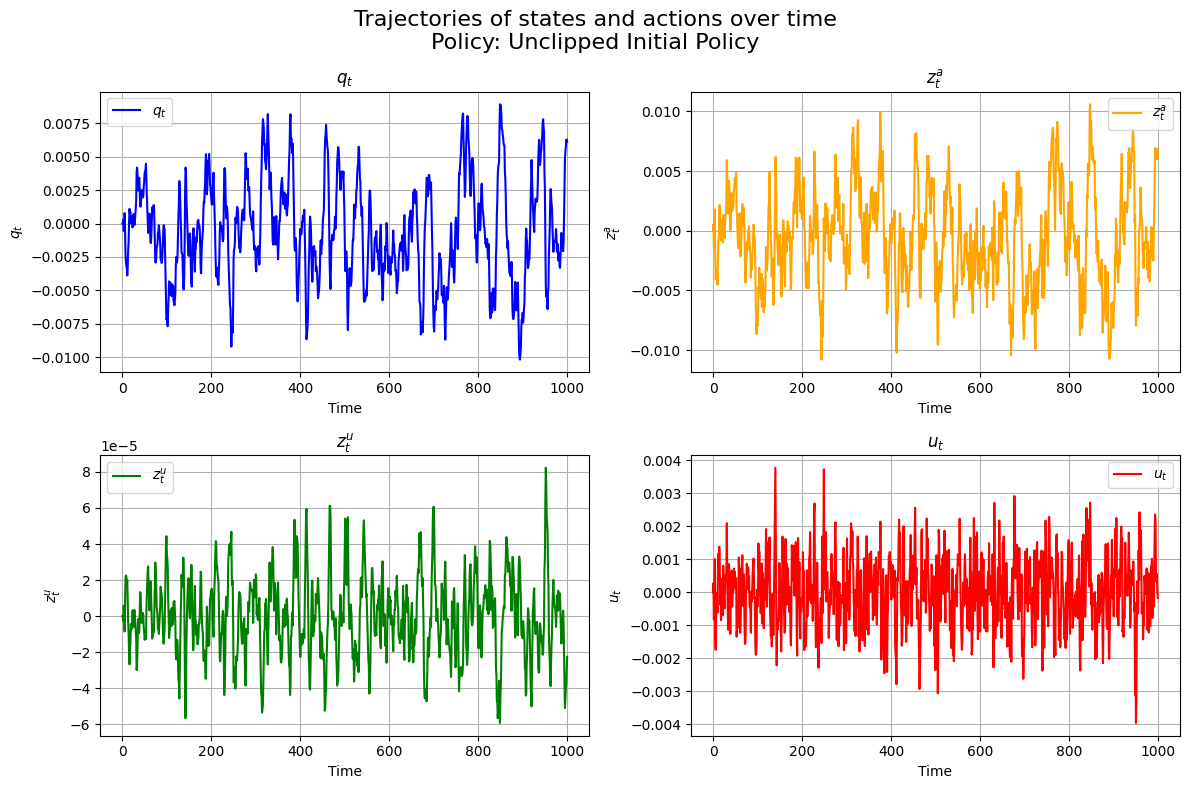

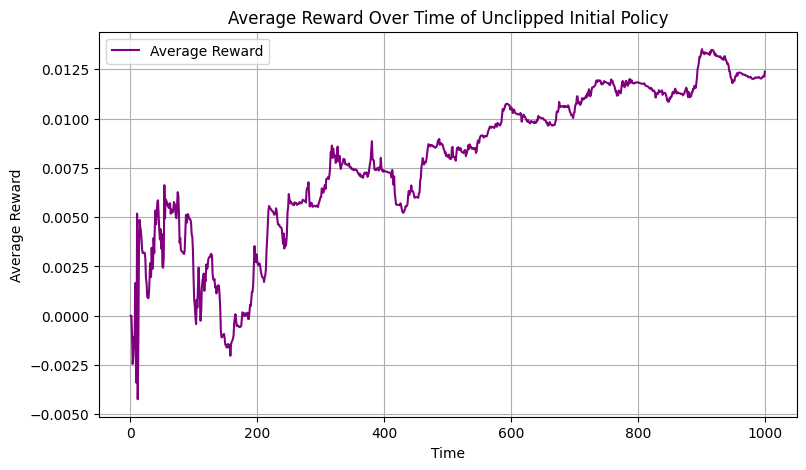

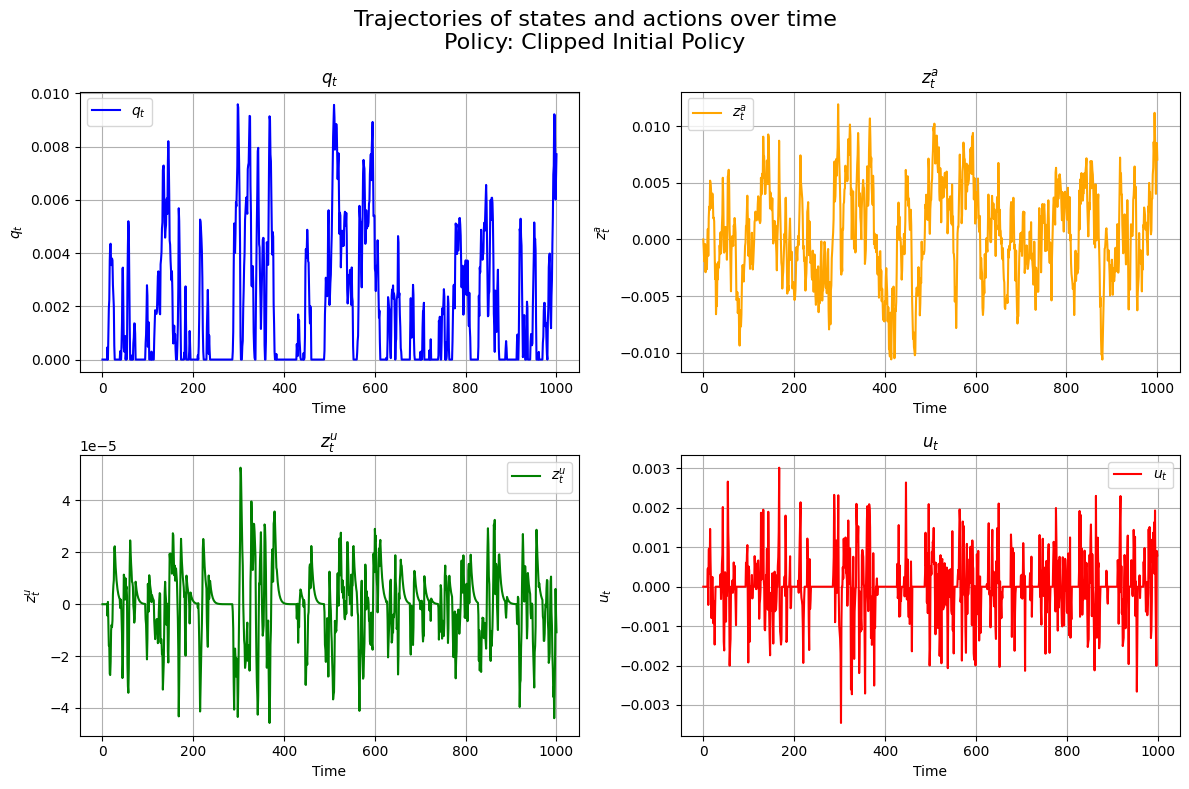

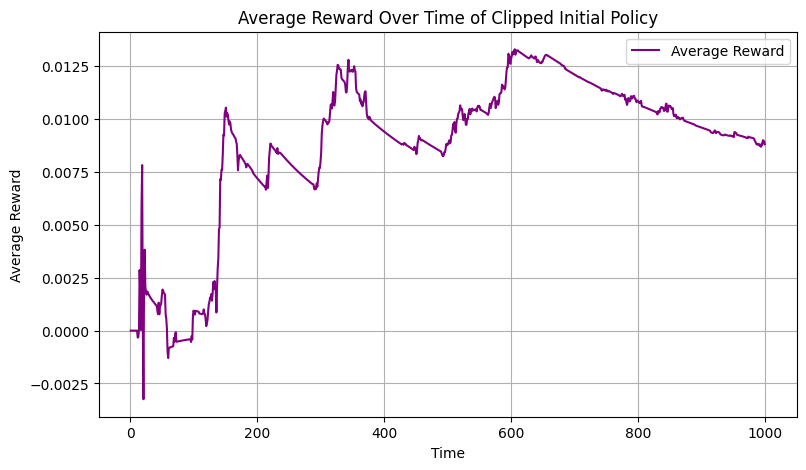

In [194]:
rng = np.random.default_rng(42)  # For reproducibility

# Question 3.1.1
policy = lambda x: -0.5 * x[0] + 0.5 * x[1] + 0.5 * x[2]
cliped_policy = lambda x: np.clip(policy(x), -x[0], 1-x[0])
random_policy = lambda x: rng.uniform(-x[0] * 0.1, (1 - x[0]) * 0.1)

x, u, xi_p = generate_trajectories(policy, x0=(0, 0, 0), T=1000)
plot_trajectories(x, u, xi_p, filename="question_3_1_unclipped", policy_name="Unclipped Initial Policy")
plot_average_reward(x, u, xi_p, filename="question_3_1_unclipped", policy_name="Unclipped Initial Policy")


x, u, xi_p = generate_trajectories(cliped_policy, x0=(0, 0, 0), T=1000)
plot_trajectories(x, u, xi_p, filename="question_3_3_clipped", policy_name="Clipped Initial Policy")
plot_average_reward(x, u, xi_p, filename="question_3_3_clipped", policy_name="Clipped Initial Policy")


# x, u, xi_p = generate_trajectories(random_policy, x0=(0, 0, 0), T=1000)
# plot_trajectories(x, u, xi_p, filename="question_3_1_1_random")
# plot_average_reward(x, u, xi_p, filename="question_3_1_1_random")

policy_list = [(policy, "Initial Policy"), (cliped_policy, "Clipped Initial Policy")]



In [195]:
### simulate trajectories and plot the average reward over time

rng = np.random.default_rng(42)  # For reproducibility

# Question 3.1.2
def run_trajectories(policy, N=1000, name="policy", show_all=False, T=1000, show_progress=False):
    """Run N trajectories using the given policy and plot the average reward over time."""
    if show_all:
        all_x = np.zeros(( T+1, 3, N))
        all_u = np.zeros((T, N))
        all_xi_p = np.zeros((T, N))

    all_rewards = np.zeros((T, N))

    # for i in range(N):
    #     x, u, xi_p = generate_trajectories(policy, x0=(0, 0, 0), T=T)
    #     if show_all:
    #         all_x[i] = x
    #         all_u[i] = u
    #         all_xi_p[i] = xi_p
    #     all_rewards[i] = reward(x, u, xi_p, T)

    all_x, all_u, all_xi_p = generate_trajectories(policy, x0=(0, 0, 0), T=T, N=N, show_progress=show_progress)
    all_rewards = reward(all_x[:, :, :], all_u[:, :], all_xi_p[:, :], T).T

    reward_mean = np.nanmean(all_rewards, axis=0) # average reward for each time step
    # skip nan values
    print(f"Average reward of {name} over {N} trajectories: {np.nanmean(all_rewards)} and std: {np.std(all_rewards)}")


    ### Cumulative reward
    plt.figure(figsize=(9, 5))
    # for i in range(N):
    #     plt.plot(np.arange(1, T+1), np.cumsum(all_rewards[i]) / (np.arange(1, T+1)), color='gray', alpha=0.05)
    # plt.plot(np.arange(1, T+1), np.cumsum(reward_mean) / (np.arange(1, T+1)), label='Average Reward', color='purple')

    # just the reward
    for i in range(N):
        plt.plot(np.arange(1, T+1), all_rewards[i], color='gray', alpha=0.05)
    plt.plot(np.arange(1, T+1), reward_mean, label='Average Reward', color='purple')
    plt.title(f'Average Reward by time of {name} Over {N} trajectories')
    plt.xlabel('Time')
    plt.ylabel('Average Reward')
    plt.grid()
    # Save cumulative reward plot
    filename_safe = name.replace(" ", "_").lower()
    plt.savefig(f"figures/{filename_safe}_cumulative_reward_{N}_trajectories.svg", format='svg')
    plt.show()


    ### show the reward distribution
    plt.figure(figsize=(9, 5))
    plt.hist(np.nanmean(all_rewards, axis=1), bins=50, color='purple', alpha=0.7, density=True)
    # max_reward = np.max(all_rewards, axis=1)
    # all_rewards[:, -1]
    reward_final_mean = np.nanmean(all_rewards)
    reward_final_var = np.var(all_rewards)
    plt.text(0.02, 0.98, f'Mean: {reward_final_mean:.2e}\nVar: {reward_final_var:.2e}', transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    # show the mean as a dashed line
    plt.axvline(reward_final_mean, color='darkviolet', linestyle='dashed', label='Mean')
    plt.legend()

    plt.title(f'Average Reward Distribution of {name} Over {N} trajectories')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    plt.grid()
    # Save final reward distribution plot
    plt.savefig(f"figures/{filename_safe}_final_reward_distribution_{N}_trajectories.svg", format='svg')
    plt.show()


    if show_all:
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        for i in range(N):
            plt.plot(np.arange(T+1), all_x[:, 0, i], color='blue', alpha=0.05)
        plt.title(r'$q_t$ over all trajectories')
        plt.xlabel('Time')
        plt.ylabel(r'$q_t$')
        plt.grid()
        plt.subplot(3, 1, 2)
        for i in range(N):
            plt.plot(np.arange(T+1), all_x[:, 1, i], color='orange', alpha=0.05)
        plt.title(r'$z^{a}_{t}$ over all trajectories')
        plt.xlabel('Time')
        plt.ylabel(r'$z^{a}_{t}$')
        plt.grid()
        plt.subplot(3, 1, 3)
        for i in range(N):
            plt.plot(np.arange(T+1), all_x[:, 2, i], color='green', alpha=0.05)
        plt.title(r'$z^{u}_{t}$ over all trajectories')
        plt.xlabel('Time')
        plt.ylabel(r'$z^{u}_{t}$')
        plt.grid()
        plt.tight_layout()
        # Save state trajectories plot
        plt.savefig(f"figures/{filename_safe}_state_trajectories_{N}_trajectories.svg", format='svg')
        # plt.show()

        ### show the distribution of all the state at all the times
        plt.figure(figsize=(12, 8))
        ax1 = plt.subplot(3, 1, 1)
        plt.hist(all_x[:, 0, :].flatten(), bins=50, color='blue', alpha=0.7, weights=np.ones_like(all_x[:, 0, :].flatten()) / all_x[:, 0, :].flatten().size)
        plt.title(r'Distribution of $q_t$ over all trajectories and times')
        plt.xlabel(r'$q_t$')
        plt.ylabel('Probability Density')
        plt.grid()
        # Add variance as text box
        q_var = np.var(all_x[:, 0, :].flatten())
        q_mean = np.nanmean(all_x[:, 0, :].flatten())
        plt.text(0.02, 0.98, f'Mean: {q_mean:.2e}\nVar: {q_var:.2e}', transform=ax1.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        ax2 = plt.subplot(3, 1, 2, sharex=ax1, sharey=ax1)
        plt.hist(all_x[:, 1, :].flatten(), bins=50, color='orange', alpha=0.7, weights=np.ones_like(all_x[:, 1, :].flatten()) / all_x[:, 1, :].flatten().size)
        plt.title(r'Distribution of $z^{a}_{t}$ over all trajectories and times')
        plt.xlabel(r'$z^{a}_{t}$')
        plt.ylabel('Probability Density')
        plt.grid()
        # Add variance as text box
        za_var = np.var(all_x[:, 1, :].flatten())
        za_mean = np.nanmean(all_x[:, 1, :].flatten())
        plt.text(0.02, 0.98, f'Mean: {za_mean:.2e}\nVar: {za_var:.2e}', transform=ax2.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        

        ax3 = plt.subplot(3, 1, 3, sharey=ax1)
        plt.hist(all_x[:, 2, :].flatten(), bins=50, color='green', alpha=0.7, weights=np.ones_like(all_x[:, 2, :].flatten()) / all_x[:, 2, :].flatten().size)
        plt.title(r'Distribution of $z^{u}_{t}$ over all trajectories and times')
        plt.xlabel(r'$z^{u}_{t}$')
        plt.ylabel('Probability Density')
        plt.grid()
        # Add variance as text box
        zu_var = np.var(all_x[:, 2, :].flatten())
        zu_mean = np.nanmean(all_x[:, 2, :].flatten())
        plt.text(0.02, 0.98, f'Mean: {zu_mean:.2e}\nVar: {zu_var:.2e}', transform=ax3.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        # Save state and reward distributions plot
        plt.savefig(f"figures/{filename_safe}_state_distributions_{N}_trajectories.svg", format='svg')
        # plt.show()



def compare_policies(policy1, policy2, N=100):
    # generate random x of shape (3, N)
    x = np.random.randn(3, N)
    x[0, :] = np.clip(x[0, :], 0, 1)  # ensure x[0] in [0, 1]
    x[1, :] = np.clip(x[1, :], -0.01, 0.01)  # ensure x[1] in [-0.01, 1]
    x[2, :] = np.clip(x[2, :], -0.01, 0.01)  # ensure x[2] in [-5, 5]

    u1 = policy1(x)
    u2 = policy2(x)
    diff = np.abs(u1 - u2)
    print(f"Max difference between policies: {np.max(diff)}")
    print(f"Mean difference between policies: {np.mean(diff)}")



# run_trajectories(policy, N=N, name="unclipped policy", show_all=True)
# run_trajectories(cliped_policy, N=N, name="clipped policy", show_all=True)


In [ ]:
# Finding the best policy by random search


def test_policy(policy, N=1000):
    reward_value = 0
    all_x, all_u, all_xi_p = generate_trajectories(policy, x0=(0, 0, 0), T=1000, N=N)
    all_rewards = reward(all_x[:, :, :], all_u[:, :], all_xi_p[:, :], 1000).T
    reward_value = np.nanmean(all_rewards)
    return reward_value

def get_linear_policy(params):
    return lambda x: np.clip(params @ np.array([x[0], x[1], x[2]]) , -x[0], 1 - x[0])

def linear_function(params, N=100): # linear function
    policy = get_linear_policy(params)
    reward_value = test_policy(policy, N=N)
    return reward_value

def get_quadratic_policy(params):
    return lambda x: np.clip(params @ np.array([x[0], x[1], x[2], x[0]**2, x[1]**2, x[2]**2, x[0]*x[1], x[0]*x[2], x[1]*x[2], np.ones_like(x[0])])
                               , -x[0], 1 - x[0])

def quadratic_function(params, N=100): # 10 params
    # quadratic function
    policy = get_quadratic_policy(params)
    reward_value = test_policy(policy, N=N)
    return reward_value




In [197]:
#### SCIPY NOT WORKING WELL


# # Advanced optimization for policy search (example: Differential Evolution and Bayesian Optimization)
# from scipy.optimize import differential_evolution

# if target_function == linear_function:
#     param_bounds = [(-100.0, 100.0)] * 3
# else:
#     param_bounds = [(-100.0, 100.0)] * 10


# # result = differential_evolution(lambda params: -target_function(params), param_bounds, seed=42, maxiter=100, polish=True)
# # print in real time the progress of the optimization
# result = differential_evolution(lambda params: -target_function(params, N=1000),  param_bounds, seed=42, maxiter=100, 
#                                 polish=True, callback=lambda x, f: print(f"Current best reward: {-f} with params: {" ".join([f'{p:.4f}' for p in x])}"))
# best_params_de = result.x

# print('Best reward (DE):', -result.fun)
# print('Best params (DE):', result.x)
# print(f"ALL outputs : {result}")


# # Best reward (DE): 0.00014893476071625646
# # [-0.03010771  0.98899323  0.30023768  0.02542109 -0.11388999  0.04947695 0.75390886 -0.4405498   0.30153338  0.00570656]
# # [-0.03502989  0.93203422  0.85333061  0.02800826 -0.38609742 -0.41453566  0.58533717  0.38185557 -0.93132613  0.0058954 ]
# #Average reward of best policy (DE) over 1000 trajectories: 0.00012731321932935195 and std: 0.004505140123694079

# # [-0.0326857   0.99948075 -0.83836307  0.01297369 -0.32935196 -0.16898026 0.93881118  0.74922339  0.13095927  0.01325202]
# # Average reward of best policy (DE) over 1000 trajectories: 0.00013211187504596597 and std: 0.010698030071014887


# # Best params (DE): [ 4.12655385e-04  9.14383436e+00  5.07172512e-01 -1.21986547e-01
# #   3.11259952e+00 -2.23009240e+00  8.06625065e+00 -6.74134828e+00
# #   7.11042371e+00  2.20034138e-02]
# # Average reward of best policy (DE) over 1000 trajectories: 0.0006561312720513467 and std: 0.010407829783256821
 

# best_policy_de = get_quadratic_policy(best_params_de)
# run_trajectories(best_policy_de, N=1000, name="best policy (DE)", show_all=True)

### CMA

In [198]:
# !pip install cma

import cma


# es = cma.CMAEvolutionStrategy([0]*3, 1, {'seed': 42,
#     'maxfevals': 20000,     
#     'popsize':100,           # increase population size for noisy problems
# })
# ### 0.5 is the initial standard deviation, increase it for more exploration
# es.optimize(lambda params: -linear_function(params, N=1000))#, verb_disp=1)
# # verb_disp=1 to see the progress in real time
# best_params_cma = es.result.xbest
# best_policy_cma = get_linear_policy(best_params_cma)
# policy_list.append((best_policy_cma, "Best linear Policy (CMA-ES)"))
# print(f"Best reward : {-es.result.fbest} with params : {' '.join([f'{p:.4f}' for p in es.result.xbest])}")


best_params_cma = np.array([-0.8864, 2.1253, 1.2096])
best_policy_cma = get_linear_policy(best_params_cma)
policy_list.append((best_policy_cma, "Best linear Policy (CMA-ES)"))

# 17 minutes

In [199]:
# CMA-ES optimization
# es = cma.CMAEvolutionStrategy([0]*10, 1, {'seed': 42, 
#     'maxfevals': 20000,     
#     'popsize':100,           # increase population size for noisy problems
# })
# ### 0.5 is the initial standard deviation, increase it for more exploration
# es.optimize(lambda params: -quadratic_function(params, N=1000))
# # verb_disp=1 to see the progress in real time
# best_params_cma_quadratic = es.result.xbest
# best_policy_cma_quadratic = get_quadratic_policy(best_params_cma_quadratic)
# if -es.result.fbest > -0.000005:
#     policy_list.append((best_policy_cma_quadratic, "Best quadratic Policy (CMA-ES)"))
# print(f"Best reward : {-es.result.fbest} with params : {' '.join([f'{p:.4f}' for p in es.result.xbest])}")
# 21 min

Average reward of best policy (CMA-ES) over 100 trajectories: 0.007929425946667795 and std: 0.13226264746880306


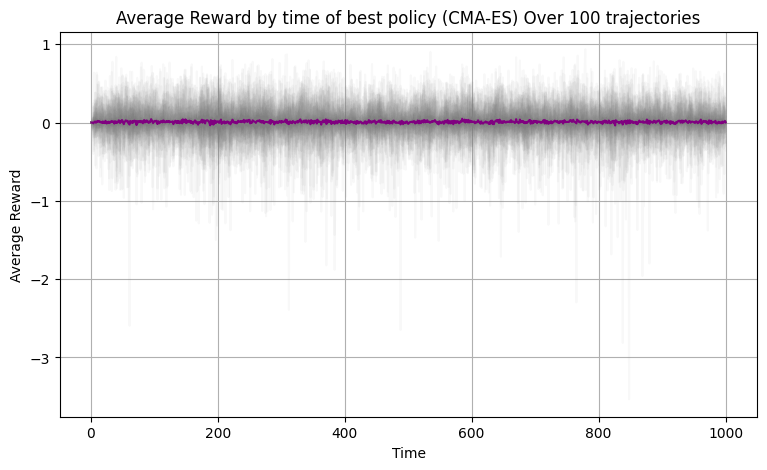

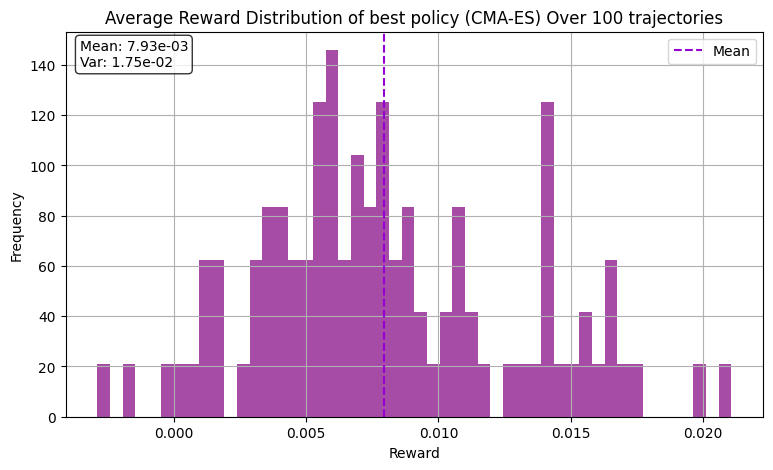

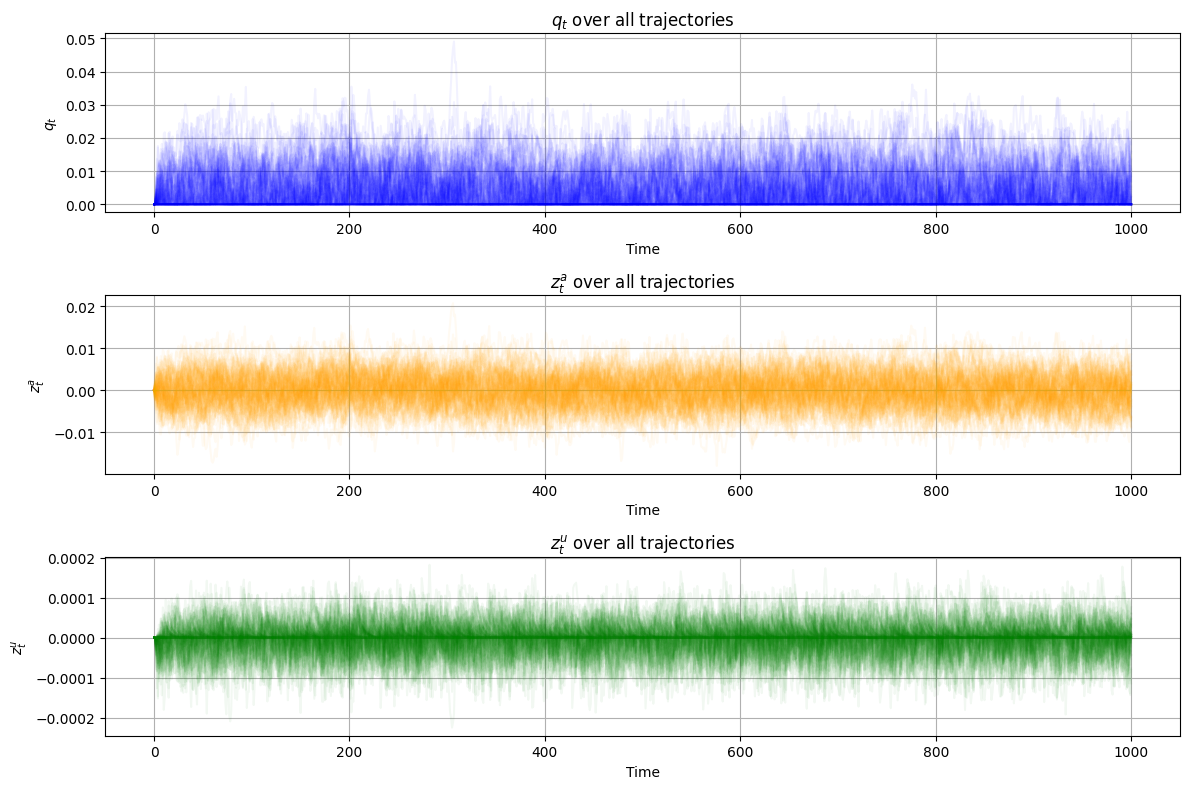

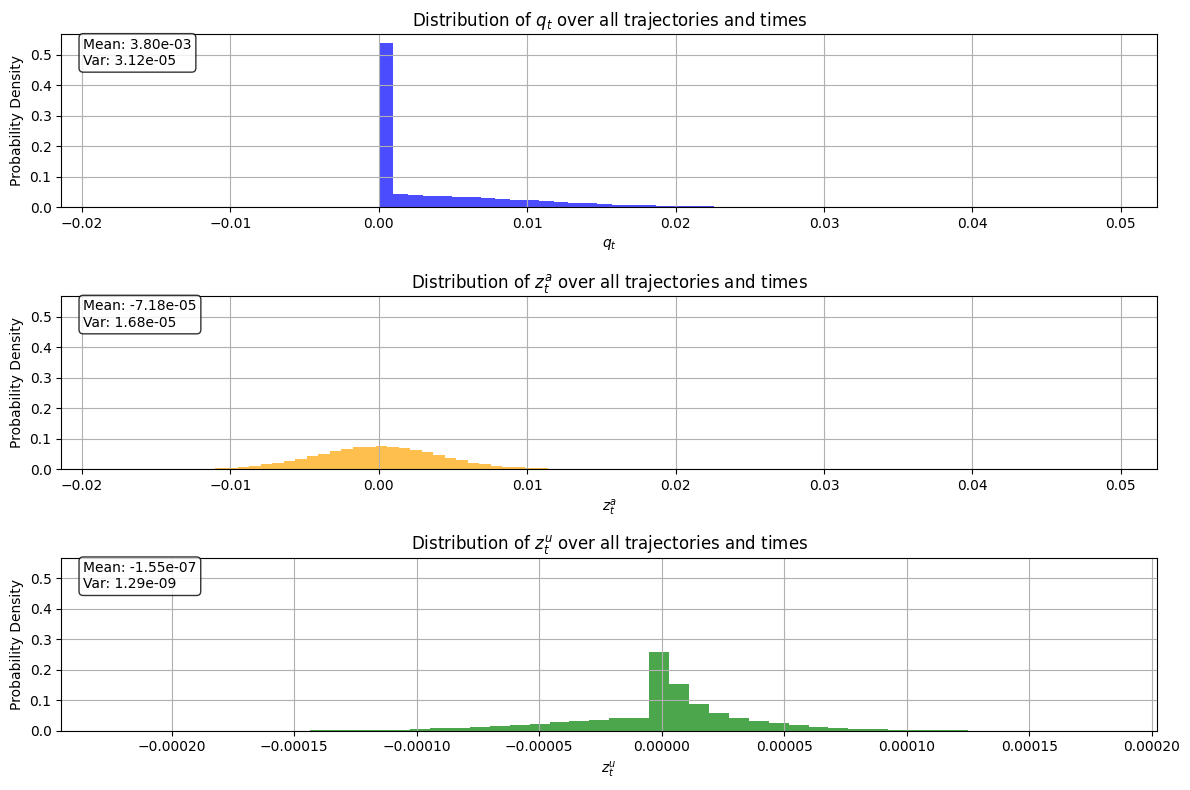

In [200]:
# print(f"best params (CMA-ES): {best_params_cma}")
# best_policy_cma = get_linear_policy(best_params_cma)
run_trajectories(best_policy_cma, N=100, name="best policy (CMA-ES)", show_all=True)

# run_trajectories(best_policy_cma_quadratic, N=1000, name="best quadratic policy (CMA-ES)", show_all=True)

In [201]:

# x, u, xi_p = generate_trajectories(best_params_cma_quadratic, x0=(0, 0, 0), T=1000)
# plot_trajectories(x, u, xi_p, filename="question_3_1_1_clipped")
# plot_average_reward(x, u, xi_p, filename="question_3_1_1_clipped")

# Question 4.4 

K_opt : [[ 1.11182191 -2.64863317 -2.52792524]]  residual norm: 5.4606211020642276e-11
Average approximate reward J: 0.019355062306099072
Stable: True
Average reward of LQR Optimal Policy over 100 trajectories: 0.017711548223165518 and std: 0.18570173324372902


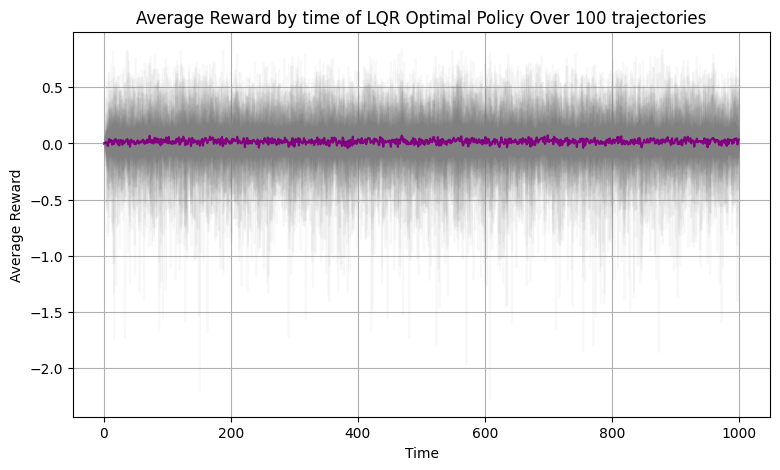

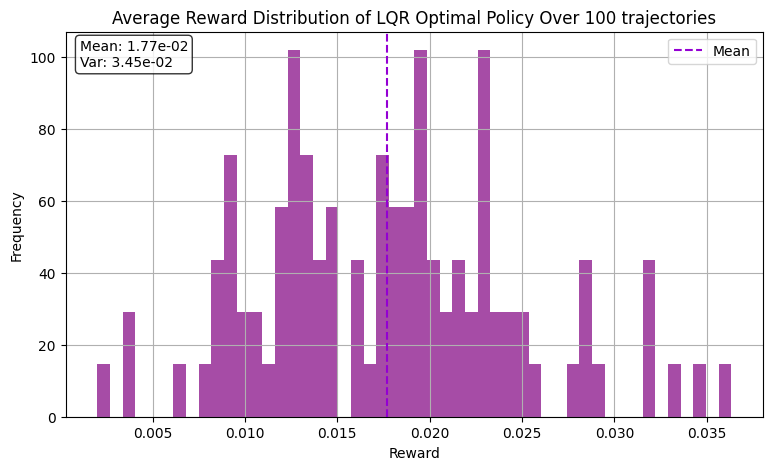

Average reward of LQR Clip Policy over 100 trajectories: 0.008579884248220988 and std: 0.13251454876678073


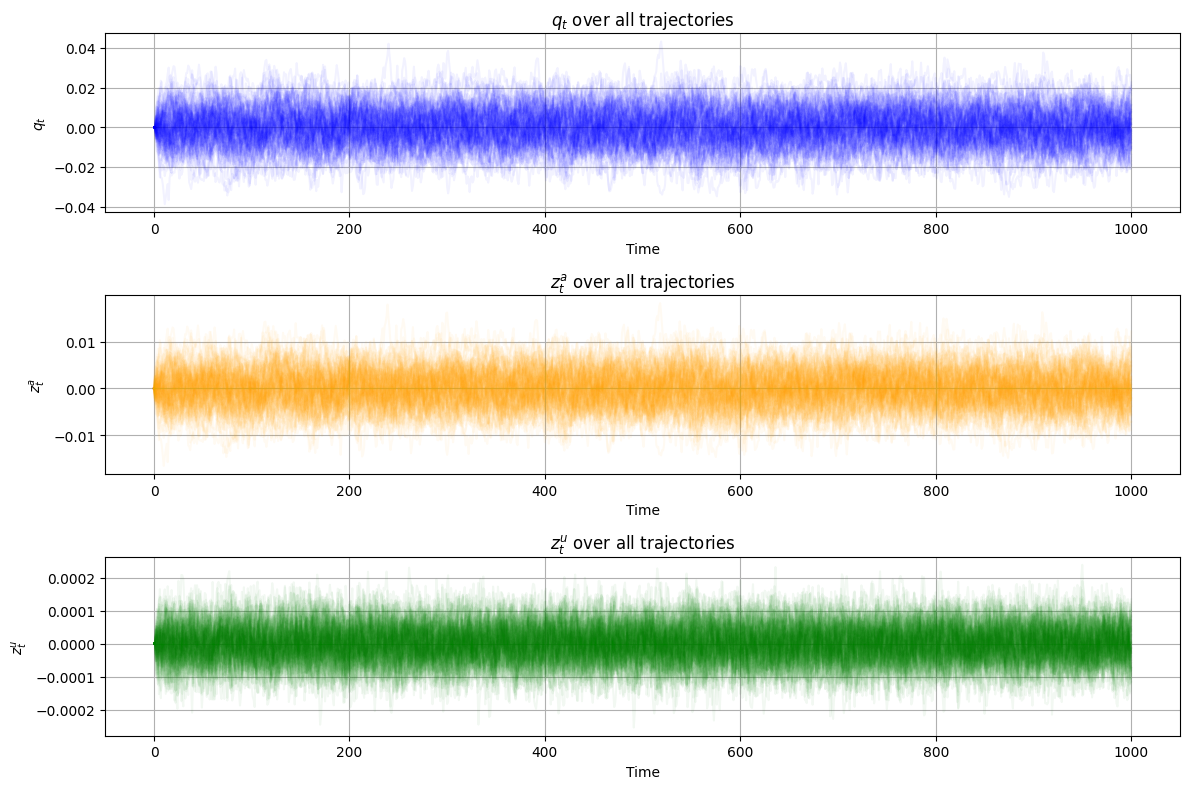

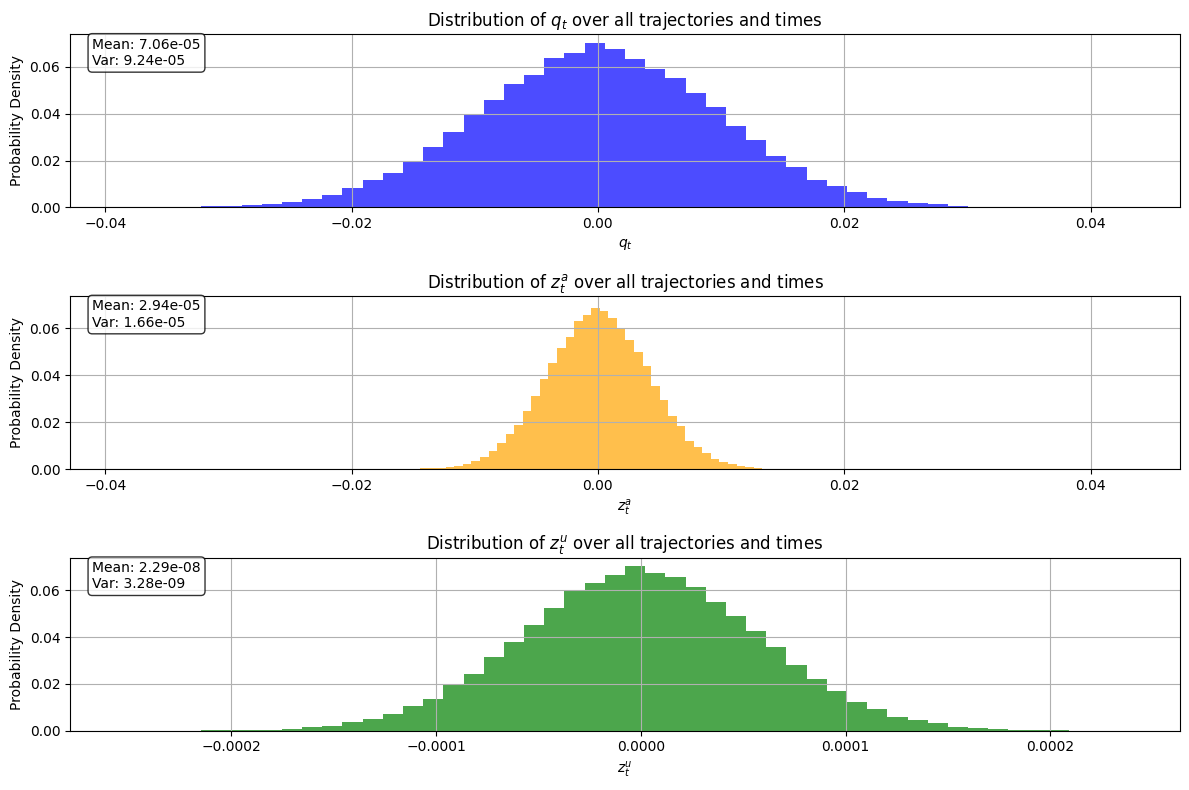

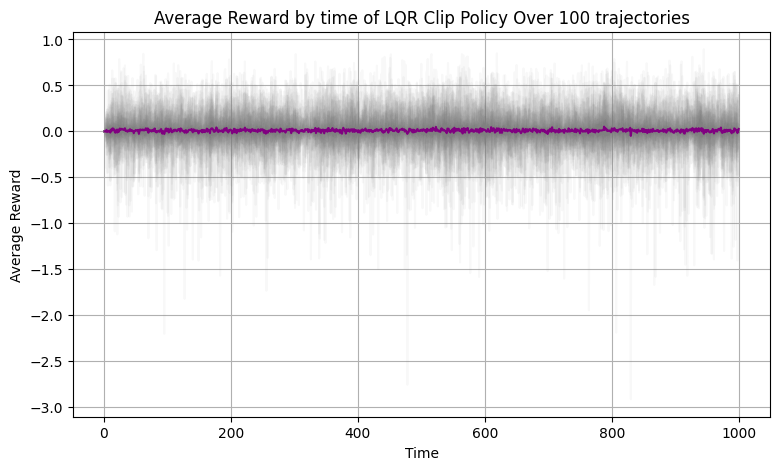

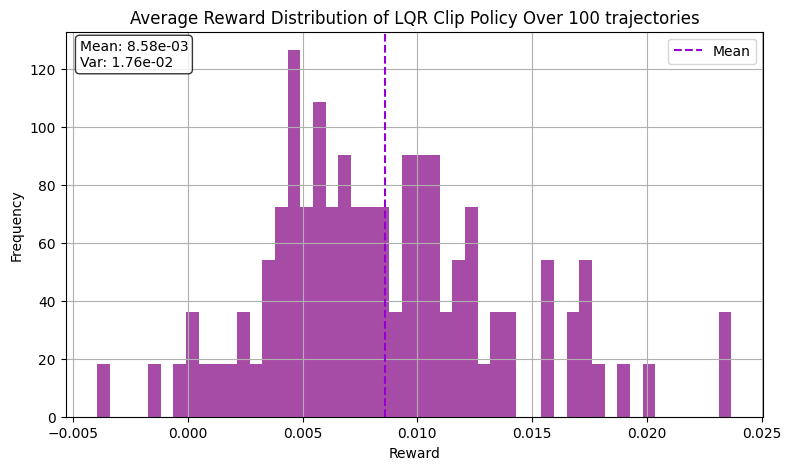

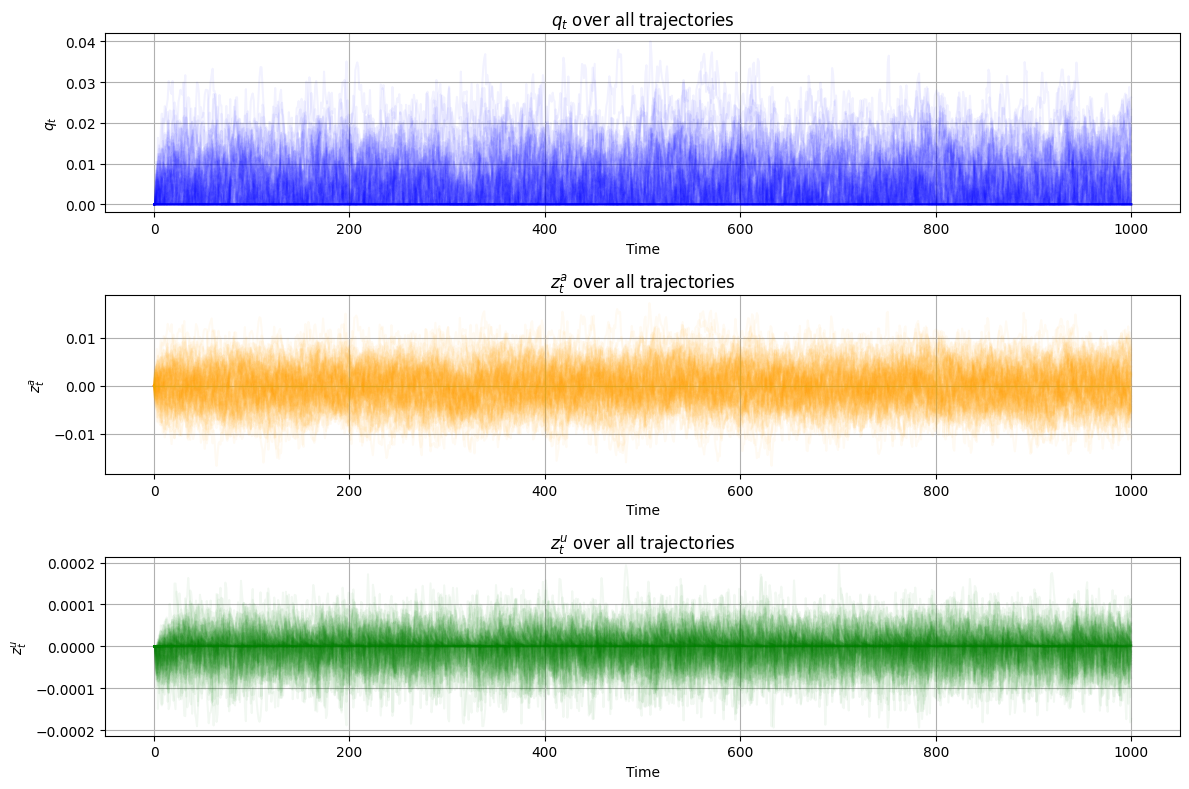

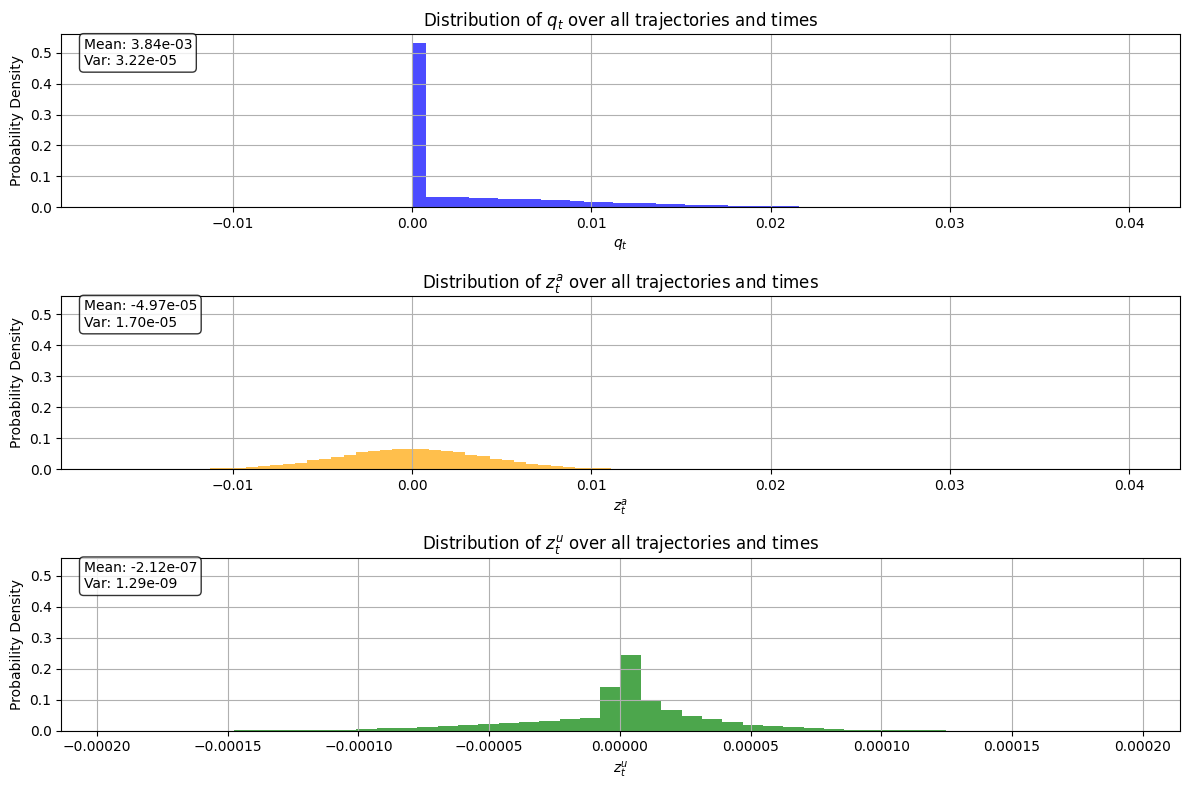

In [202]:
np.random.seed(42)


from scipy.linalg import solve_discrete_are

# def c(g):
#     """Compute the net stage reward given gross stage reward g_t for each time t"""
#     # return np.maximum(g - (np.pow(g, 2) / 2), 1 - np.exp(-g))
#     return g - (np.pow(g, 2) / 2)

def solve_ricatti_infinite_horizon(A, B, Q, R, S, max_iterations=10_000, tolerance=1e-10):
    """Solve the discrete-time algebraic Riccati equation for infinite horizon LQR.
    """
    # Initialize with Q (not zero) for better convergence
    P = Q.copy()
    for i in range(max_iterations):
        # CORRECT Riccati iteration for MINIMIZATION problem
        P_next = Q + A.T @ P @ A - (A.T @ P @ B + S) @ np.linalg.inv(R + B.T @ P @ B) @ (B.T @ P @ A + S.T)

        if np.abs(np.max(P - P_next)) < tolerance:
            print(f"Converged after {i+1} iterations")
            break
        P = P_next
    else:
        print("Warning: Riccati iteration did not converge")
    
    return P

def optimal_gain(A, B, Q, R, S, M):
    K = np.linalg.inv(R + B.T @ M @ B) @ (B.T @ M @ A + S.T)
    return K

# Define system matrices based on the problem description
F = np.array([[1, 0, 0], 
              [0, 1 - W_A, 0], 
              [0, 0, 1 - W_U]])

G = np.array([[1], 
              [0], 
              [W_U * BETA_U]])

D = np.array([[0, 0], [W_A * SIGMA_A, 0], [0, 0]])  # Disturbance matrix
  
# maximise r = 0.5 x.T Q x + 0.5 u.T R u + x.T N u
# minimise E(sum(-r))
# given    x_t+1 = F x_t + G u_t + D xi_t

Q = np.array([[-(1000 * SIGMA_P)**2, 1000, 1000], 
                     [1000, 0, 0], 
                     [1000, 0, 0]]) 

R = - (1000 * THETA * SIGMA_P)**2

P = np.array([[1000*GAMMA_U - THETA * ((1000 * SIGMA_P)**2)], 
                     [1000 * THETA], 
                     [1000 * THETA]]) 

# min x.T Q x + u.T R u + 2 x.T S u
Q = -0.5 * Q
R = -0.5 * R
S = -0.5 * P

R = np.array([[R]], dtype=float)             # make it (1x1) PD


# M = solve_ricatti_infinite_horizon(F, G, Q, R, S)
# K_opt = optimal_gain(F, G, Q, R, S, M)

M = solve_discrete_are(F, G, Q, R, e=np.eye(3), s=S)
K_opt = np.linalg.solve(R + G.T @ M @ G, (G.T @ M @ F + (1*S).T))

residual = F.T @ M @ F - (F.T @ M @ G + S) @ np.linalg.inv(R + G.T @ M @ G) @ (G.T @ M @ F + S.T) + Q - M
print(f"K_opt : {K_opt}  residual norm: {np.linalg.norm(residual, ord='fro')}")



K_opt = - np.array([[-0.8864, 2.1253, 1.2096]])


# Compute average approximate reward
J = - np.linalg.trace(M @ D @ D.T)
print("Average approximate reward J:", J)


def lqr_policy(x):
    u = -K_opt @ x
    return u

def lqr_clip_policy(x):
    return np.clip(lqr_policy(x), -x[0], 1 - x[0])


# Check closed-loop stability
F_cl = F - G @ K_opt
eigenvalues = np.linalg.eigvals(F_cl)
print("Stable:", all(np.abs(eigenvalues) < 1))


print("=" * 50)
# x, u, xi_p = generate_trajectories(lqr_policy, x0=(0, 0, 0), T=1000, N=1000)
# x, u, xi_p = generate_trajectories(lqr_clip_policy, x0=(0, 0, 0), T=1000, N=1000)


# x, u, xi_p = generate_trajectories(lqr_policy, x0=(0, 0, 0), T=1000, N=10, xi_p=np.zeros((1000, 10)))
# plot_average_reward(x, u, xi_p, filename="lqr_optimal_policy")
# plot_trajectories(x, u, xi_p, filename="lqr_optimal_policy")


# print(f"LQR Optimal Policy Average Reward: {average_reward(x, u, xi_p, 1000)}")
# # plot_trajectories(x, u, xi_p, T=1000)
# # plot_average_reward(x, u, xi_p, filename="lqr_optimal_policy")
run_trajectories(lqr_policy, N=100, T=1000, name="LQR Optimal Policy", show_all=True)
run_trajectories(lqr_clip_policy, N=100, T=1000, name="LQR Clip Policy", show_all=True)


policy_list.append((lqr_policy, "LQR Optimal Policy"))
policy_list.append((lqr_clip_policy, "LQR Clip Policy"))

In [203]:

# # %pip install cvxpy
# import cvxpy as cp
#### MPC via CVXPY not working because problem is not DCP
# def solve_mpc(x0, N, nu, nx, ny, F, G, H, E, Q, R, S, R_0,
#               u_min, u_max, y_min, y_max):
#     ###### solve
#     # min z.T @ R_0 @ z + sum (z.T @ Q @ z + q.T @ R @ q + z.T @ S @ u)
#     # z_0 = x(t)
#     # z_k+1 = F z_k + G q_k
#     # w_k = H z_k + E q_k
#     # u_min <= q_k <= u_max
#     # y_min <= w_k <= y_max

#     P = np.block([[Q,  S],
#                   [S.T, R]])

#     # Symmetrize weights (numerical safety)
#     Q  = 0.5 * (Q + Q.T)
#     R  = 0.5 * (R + R.T)
#     R_0 = 0.5 * (R_0 + R_0.T)
#     P  = 0.5 * (P + P.T)

#         # Require R ≻ 0 (needed for the completion)
#     # If R is scalar, promote; otherwise check PD
#     try:
#         R_inv = np.linalg.inv(R)
#     except np.linalg.LinAlgError:
#         raise ValueError("R must be positive definite (invertible) for the cross-term rewrite.")

#     # ---- CVXPY variables ----
#     z = [cp.Variable(nx) for _ in range(N + 1)]
#     q = [cp.Variable(nu) for _ in range(N)]

#     constraints = [z[0] == np.asarray(x0, dtype=float).reshape(nx)]

#     # objective = cp.quad_form(z[N], R_0)
#     objective = 0

#     for k in range(N):
#         # cost = z[k].T @ Q @ z[k] + q[k].T @ R @ q[k] + 2 * z[k].T @ S @ q[k]
#         # objective += cp.quad_form(z[k], Q) + cp.quad_form(q[k], R) + 2 * cp.quad_form(z[k], S @ q[k])
#         v_k = cp.hstack([z[k], q[k]])            # length nx + nu
#         objective += cp.quad_form(v_k, P)

#         # dynamics
#         constraints += [z[k + 1] == F @ z[k] + G @ q[k]]
        
#         # input bounds
#         for i in range(nu):
#             if u_min[i] is not None: constraints += [q[k][i] >= float(u_min[i])]
#             if u_max[i] is not None: constraints += [q[k][i] <= float(u_max[i])]
#         # output bounds
#         w_k = H @ z[k] + E @ q[k]
#         for i in range(ny):
#             if y_min[i] is not None: constraints += [w_k[i] >= float(y_min[i])]
#             if y_max[i] is not None: constraints += [w_k[i] <= float(y_max[i])]

#     prob = cp.Problem(cp.Minimize(objective), constraints)

#     # Prefer OSQP for QPs; fall back to default if unavailable.
#     # try:
#     #     prob.solve(solver=cp.OSQP, warm_start=True, eps_abs=1e-6, eps_rel=1e-6, max_iter=20000)
#     #     # Problem does not follow DCP rules. Use other solver.
#     # except Exception:
#     #     prob.solve(warm_start=True)


#     # Try nonconvex-compatible solvers
#     solved = False
#     for solver in [cp.GUROBI, cp.CPLEX, cp.MOSEK, cp.SCIPY]:
#         try:
#             prob.solve(solver=solver, warm_start=True, verbose=False, 
#             solved = prob.status in ("optimal", "optimal_inaccurate")
#             if solved:
#                 print(f"✅ Solved with {solver}")
#                 break
#         except Exception as e:
#             print(f"⚠️ Solver {solver} failed: {e}")
#             continue


#     if not solved:
#         raise RuntimeError(f"MPC QP did not solve: status={prob.status}")

#     if prob.status not in ("optimal", "optimal_inaccurate"):
#         raise RuntimeError(f"MPC QP did not solve: status={prob.status}")

#     q0 = q[0].value
#     return np.asarray(q0, dtype=float).reshape(nu)



In [ ]:

from scipy.optimize import minimize, LinearConstraint, Bounds
N = 5


nu = 1  # number of inputs  = 1
nx = 3  # number of states  = 3
ny = 3  # number of outputs = 3

H = np.eye(ny)         # Output matrix (assuming full state observation)  # ny x nx
E = np.zeros((ny, 1))  # Direct feedthrough (assuming none)  # ny x nu

# we use F, G, Q, R, S from before
# min x.T Q x + u.T R u + 2 x.T S u
R_0 = Q # last stage cost  # nx x nx

u_min, u_max = [None], [None]  # scalar
y_min = np.array([0, None, None], dtype=object)  # (ny x 1)
y_max = np.array([1, None, None], dtype=object)   # (ny x 1)


def precompute_mpc_matrices(N):
    # --- Symmetrize weights ---
    # Q, R, R_0 = map(lambda M: 0.5*(M+M.T), (Q, R, R_0))
    nZ, n = (N+1)*nx, (N+1)*nx + N*nu
    z = lambda k: slice(k*nx, (k+1)*nx)
    q = lambda k: slice(nZ + k*nu, nZ + (k+1)*nu) # slices in w

    # --- Quadratic cost matrix : min w.T [Q, S; S.T, R] w  with w = [z; q] ---
    Hobj = np.zeros((n, n))
    for k in range(N):
        Hobj[z(k), z(k)] += Q
        Hobj[q(k), q(k)] += R
        Hobj[z(k), q(k)] += S
        Hobj[q(k), z(k)] += S.T
    Hobj[z(N), z(N)] += R_0
    Hobj = 0.5 * (Hobj + Hobj.T)

    # --- Equality constraints: x(t+1) = F x(t) + G u(t) ---
    Aeq = np.zeros((nx*(N+1), n))
    Aeq[:nx, z(0)] = np.eye(nx)
    for k in range(N):
        Aeq[z(k+1), z(k+1)] = np.eye(nx)
        Aeq[z(k+1), z(k)]   = -F
        Aeq[z(k+1), q(k)]   = -G

    # --- Output constraints : y_min <= H z + E u <= y_max ---
    ymin = np.array([float(v) if v is not None else -np.inf for v in y_min])
    ymax = np.array([float(v) if v is not None else  np.inf for v in y_max])
    lb, ub = np.tile(ymin, N+1), np.tile(ymax, N+1)
    Aineq = np.zeros(((N+1)*ny, n)) # H z + E u <= y_max
    for k in range(N+1):
        Aineq[k*ny:(k+1)*ny, z(k)] = H
    for k in range(N):
        Aineq[k*ny:(k+1)*ny, q(k)] = E

    # --- Variable bounds (only q) ---
    umin = np.array([float(v) if v is not None else -np.inf for v in u_min])
    umax = np.array([float(v) if v is not None else  np.inf for v in u_max])
    lb_q, ub_q = np.full(n, -np.inf), np.full(n, np.inf)
    lb_q[nZ:], ub_q[nZ:] = np.tile(umin, N), np.tile(umax, N)

    return Hobj, Aeq, Aineq, lb, ub, lb_q, ub_q, n, nx, nu, z, q

def solve_mpc(x0, N, precomputed_matrices):
    Hobj, Aeq, Aineq, lb, ub, lb_q, ub_q, n, nx, nu, z, q = precomputed_matrices
    x0 = np.asarray(x0, dtype=float).reshape(-1)

    beq = np.zeros(nx*(N+1))
    beq[:nx] = x0
    lin_eq = LinearConstraint(Aeq, beq, beq)    # Aeq w = beq
    lin_ineq = LinearConstraint(Aineq, lb, ub)  # lb <= Aineq w <= ub
    bounds = Bounds(lb_q, ub_q)                 # lb_q <= q <= ub_q

    # --- Initial guess ---
    w0 = np.zeros(n)
    w0[z(0)] = x0

    # --- Solve ---
    # jac and hess are provided for efficiency
    res = minimize(lambda q: 0.5 * q @ (Hobj @ q), w0, method="trust-constr", jac= lambda q: Hobj @ q, hess=lambda q: Hobj,
                   constraints=[lin_eq, lin_ineq], bounds=bounds,
                   options=dict(maxiter=10000, gtol=1e-8, verbose=0))
    if not res.success:
        raise RuntimeError(f"MPC solve failed: {res.message}")
    return res.x[q(0)].reshape(nu)


def _solve_mpc(x0, N=N, precomputed_matrices=None):
    # q = solve_mpc(x0, N)
    q = np.array([solve_mpc(x0[:, i], N, precomputed_matrices) for i in range(x0.shape[1])]).T
    return q[0]


def get_mpc_policy(N):
    precomputed_matrices = precompute_mpc_matrices(N)
    return lambda x: _solve_mpc(x, N, precomputed_matrices)


mpc_policy = get_mpc_policy(N)
# test
run_trajectories(mpc_policy, N=1, T=1000, name="MPC Optimal Policy", show_all=True, show_progress=True)








Generating trajectories:  78%|███████▊  | 783/1000 [00:11<00:03, 65.98it/s]


KeyboardInterrupt: 

Generating trajectories: 100%|██████████| 1000/1000 [00:08<00:00, 123.39it/s]


Average reward of MPC Optimal Policy over 1 trajectories: 0.011299043316617475 and std: 0.157317930070485


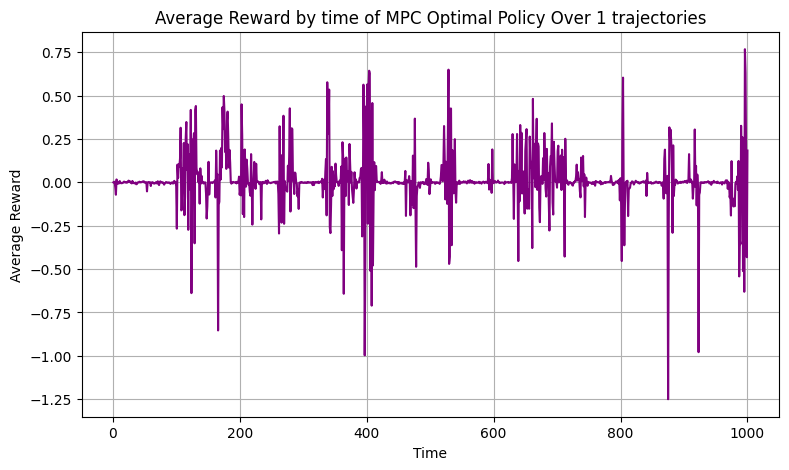

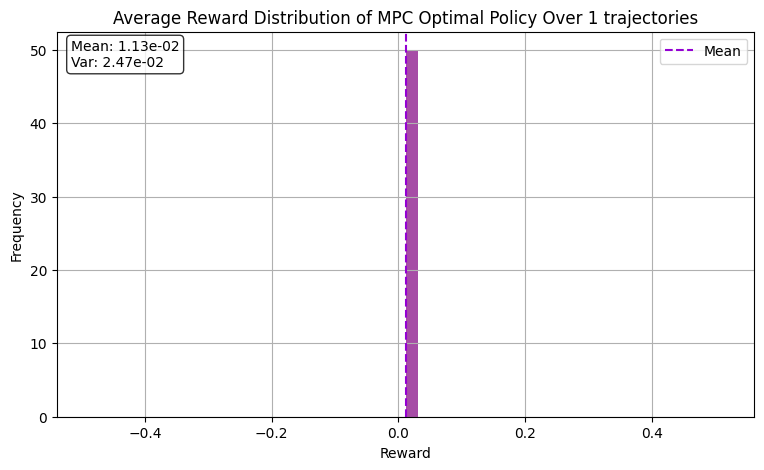

Max difference between policies: 0.02270426099740691
Mean difference between policies: 0.0014211653317665986


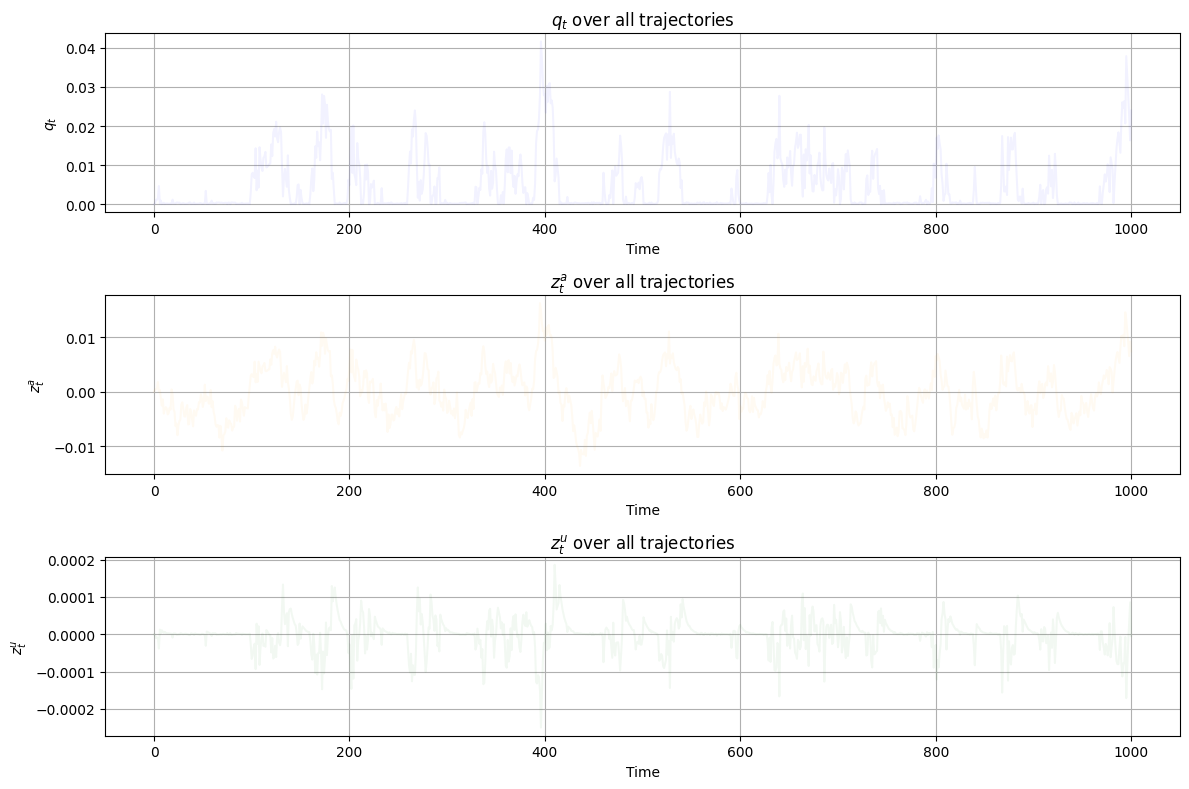

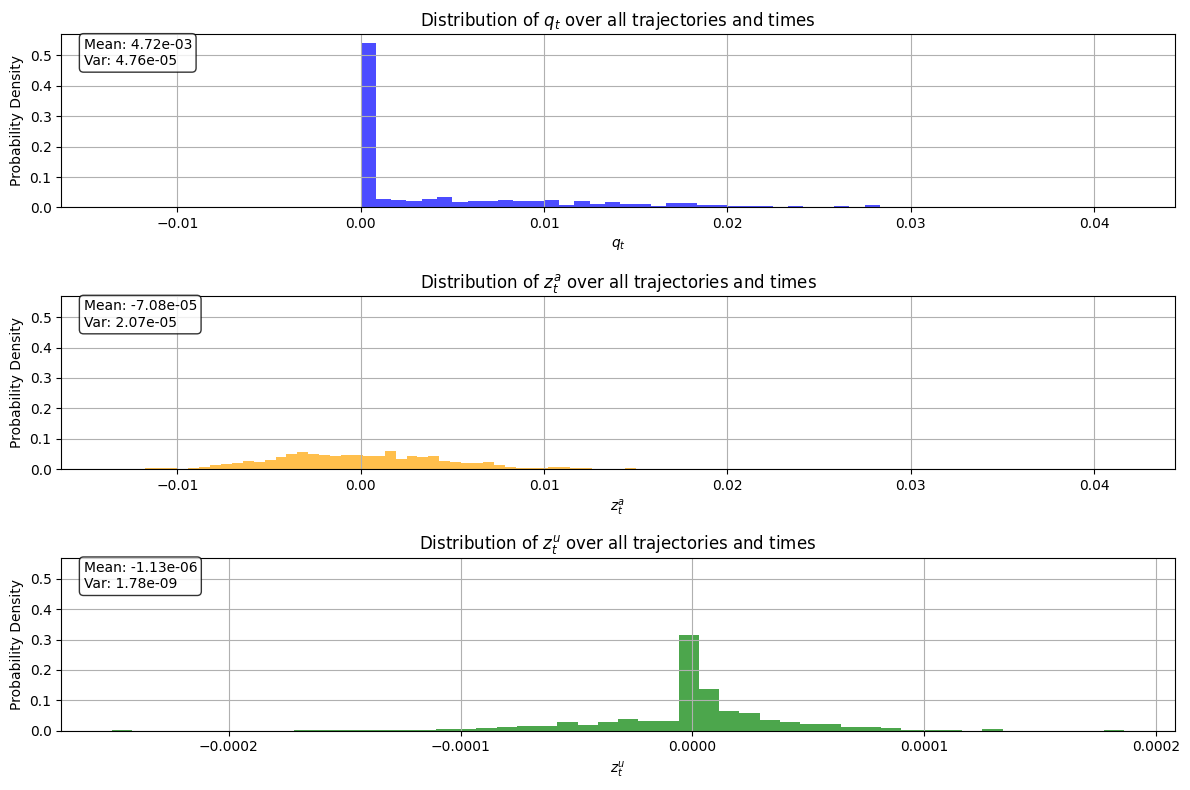

In [ ]:
### MPC

from scipy.linalg import block_diag
from scipy.optimize import minimize, LinearConstraint, Bounds


# z = FF x(t) + GG q
# w = HH z + EE q


def precompute_mpc_condensed_matrices(N):
    # Condensed MPC : min sum 0.5 q.T H_hat q + F_hat.T q
    # z_{k+1}=F z_k + G q_k, y_k=H z_k + E q_k, bounds on u and y.

    nx = F.shape[0]; nu = G.shape[1]; ny = H.shape[0]

    # --- Lifted dynamics for stages 0..N-1 (cost) and terminal N ---
    # Zstages = FF x0 + GG q, where Zstages = [z0; z1; ...; z_{N-1}]
    FF = np.vstack([np.linalg.matrix_power(F, i) for i in range(N+1)])  # (nx*(N+1)) x nx
    GG = np.zeros((nx*(N+1), nu*N))
    for i in range(1,N+1):
        for j in range(i):
            GG[i*nx:(i+1)*nx, j*nu:(j+1)*nu] = np.linalg.matrix_power(F, i-1-j) @ G

    # --- Quadratic cost 0.5 q^T Hq q + f^T q (+ const) ---
    # Qblk = np.kron(np.eye(N), Q)                 # diag(Q,...,Q)
    Qblk = block_diag(*([Q] * N + [R_0]))  # (nx*N) x (nx*N)
    Rblk = np.kron(np.eye(N), R)                 # diag(R,...,R)
    Sblk = np.zeros((nx*(N+1), nu*N))
    for i in range(N):
        Sblk[i*nx:(i+1)*nx, i*nu:(i+1)*nu] = S
    H_hat = 2*(GG.T @ Qblk @ GG + Rblk) + 2* (GG.T @ Sblk + Sblk.T @ GG)      # Hessian
    F_hat = 2*((GG.T @ Qblk @ FF) + (Sblk.T @ FF))     # linear term

    # --- Output constraints for k=0..N: y_k = H z_k + E q_k ---
    HH = np.kron(np.eye(N+1), H)  # (ny*(N+1)) x (nx*(N+1))
    EE = np.kron(np.eye(N+1), E)  # (ny*(N+1)) x (nu*(N+1))
    Yq = HH @ GG + EE[:, :nu*N]  # (ny*(N+1)) x (nu*N)
    yx = (HH @ FF)               # (ny*(N+1),)

    A_lin = np.vstack([np.eye(nu*N), Yq]) # output bounds and input bounds


    # Bounds helpers
    def arr_or_inf(v, d, lo):
        if v is None: return np.full(d, -np.inf if lo else np.inf)
        v = np.array(v, dtype=object).reshape(-1)
        out = np.where(v==None, -np.inf if lo else np.inf, v.astype(float))
        return out if out.size==d else np.tile(out, d//out.size)

    # input bounds (repeat over horizon)
    lb_u = np.tile(arr_or_inf(u_min, nu, True),  N)
    ub_u = np.tile(arr_or_inf(u_max, nu, False), N)

    lb_y = np.tile(arr_or_inf(y_min, ny, True),  N+1) 
    ub_y = np.tile(arr_or_inf(y_max, ny, False), N+1)

    return H_hat, F_hat, yx, A_lin, lb_u, ub_u, lb_y, ub_y

def mpc_condensed(x0, N, precomputed_condensed=None):
    ### using x0
    x0 = np.asarray(x0, float).reshape(-1)
    # global precomputed_condensed
    H_hat, F_hat, yx, A_lin, lb_u, ub_u, lb_y, ub_y = precomputed_condensed


    # Combine linear constraints:
    #   lb_u <= I q <= ub_u
    #   lb_y <= Yq q <= ub_y
    # output bounds (for k=0..N), then shift by -yx @ x0
    lb    = np.concatenate([lb_u, lb_y - yx @ x0])
    ub    = np.concatenate([ub_u, ub_y - yx @ x0])
    lin_con = LinearConstraint(A_lin, lb, ub)

    # Variable bounds
    bounds = Bounds(lb_u, ub_u)

    F_hat_x = F_hat @ x0
    def obj(q): return 0.5*q@H_hat@q + F_hat_x@q
    def jac(q): return H_hat@q + F_hat_x
    def hess(q): return H_hat

    q0 = np.zeros(nu*N)  # warm start
    res = minimize(obj, q0, method="trust-constr", jac=jac, hess=hess,
                   constraints=[lin_con], bounds=bounds,
                   options=dict(maxiter=10000, gtol=1e-8, xtol=1e-10, verbose=0))
    if not res.success:
        raise RuntimeError(f"MPC condensed QP failed: {res.message}")
    return res.x  # length nu*N

def _mpc_condensed(x0, N=N, precomputed_condensed=None):
    # if x0 is batched, loop over
    q = np.array([mpc_condensed(x0[:, i], N, precomputed_condensed) for i in range(x0.shape[1])]).T
    return q[0]

def get_mpc_condensed_policy(N):
    precomputed_condensed = precompute_mpc_condensed_matrices(N)
    return lambda x: _mpc_condensed(x, N, precomputed_condensed)
N = 1
mpc_policy_condensed = get_mpc_condensed_policy(N)

# test
run_trajectories(mpc_policy_condensed, N=1, T=1000, name="MPC Optimal Policy", show_all=True, show_progress=True)
# run_trajectories(mpc_policy, N=1, T=1000, name="MPC Optimal Policy", show_all=True, show_progress=True)

# x, u, xi_p = generate_trajectories(mpc_policy_condensed, x0=(0, 0, 0), T=1000, N=1, xi_p=np.zeros((1000, 10)), show_progress=True)
# plot_average_reward(x, u, xi_p, filename="lqr_optimal_policy")
# plot_trajectories(x, u, xi_p, filename="lqr_optimal_policy")

compare_policies(mpc_policy, mpc_policy_condensed, N=100)
policy_list.append((mpc_policy_condensed, "MPC Optimal Policy"))




In [ ]:
#### graphs of N vs reward
Ns = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30]
rewards = []
for N in Ns:
    pol = get_mpc_condensed_policy(N)
    rewards.append(test_policy(pol, N=1))
    print(f"N={N}, Average reward: {rewards[-1]}")

plt.figure()
plt.plot(Ns, rewards, marker='o')
plt.xlabel('MPC Horizon N')
plt.ylabel('Average Reward')
plt.title('Average Reward vs MPC Horizon')
plt.grid()
plt.savefig("figures/mpc_horizon_vs_reward.svg", format='svg')

N=2, Average reward: 0.010770393629270974
N=4, Average reward: 0.006925783929407723
N=6, Average reward: 0.004142706872346426
N=8, Average reward: 0.012085514807271505
N=10, Average reward: 0.011386943430343273
N=12, Average reward: 0.012336226930654236
N=14, Average reward: 0.007324205857089437
N=16, Average reward: 0.00993516328869454
N=18, Average reward: 0.0118827475752935


Evaluation of all policies over 10000 trajectories ...


Generating trajectories: 100%|██████████| 1000/1000 [00:00<00:00, 9121.34it/s]


Initial Policy                  Average reward = 0.01065631 , Std = 0.00293764


Generating trajectories: 100%|██████████| 1000/1000 [00:00<00:00, 6248.90it/s]


Clipped Initial Policy          Average reward = 0.00536538 , Std = 0.00234762


Generating trajectories: 100%|██████████| 1000/1000 [00:00<00:00, 7496.59it/s]


Best linear Policy (CMA-ES)     Average reward = 0.00841741 , Std = 0.00492543


Generating trajectories: 100%|██████████| 1000/1000 [00:00<00:00, 9553.18it/s]


LQR Optimal Policy              Average reward = 0.01668417 , Std = 0.00654772


Generating trajectories: 100%|██████████| 1000/1000 [00:00<00:00, 8191.76it/s]


LQR Clip Policy                 Average reward = 0.00838666 , Std = 0.00495314


Generating trajectories: 100%|██████████| 1000/1000 [00:16<00:00, 61.57it/s]


MPC Optimal Policy              Average reward = 0.01650825 , Std = 0.00000000


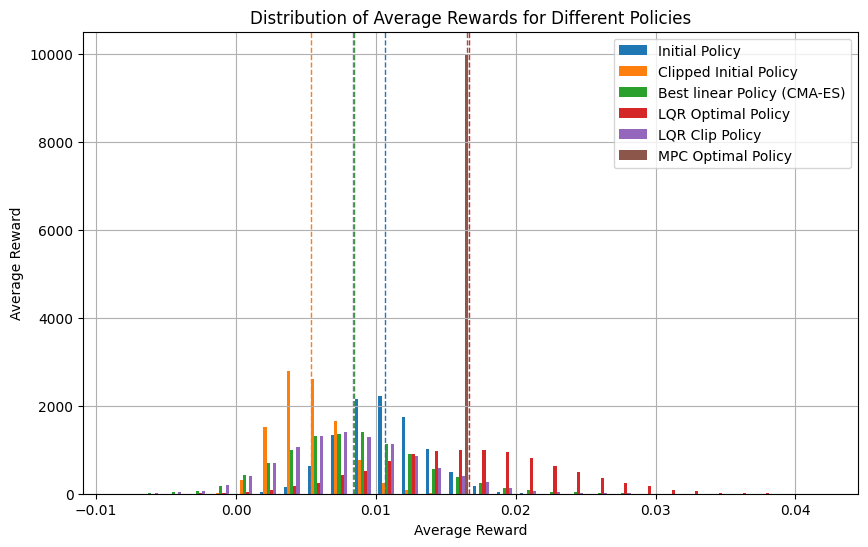

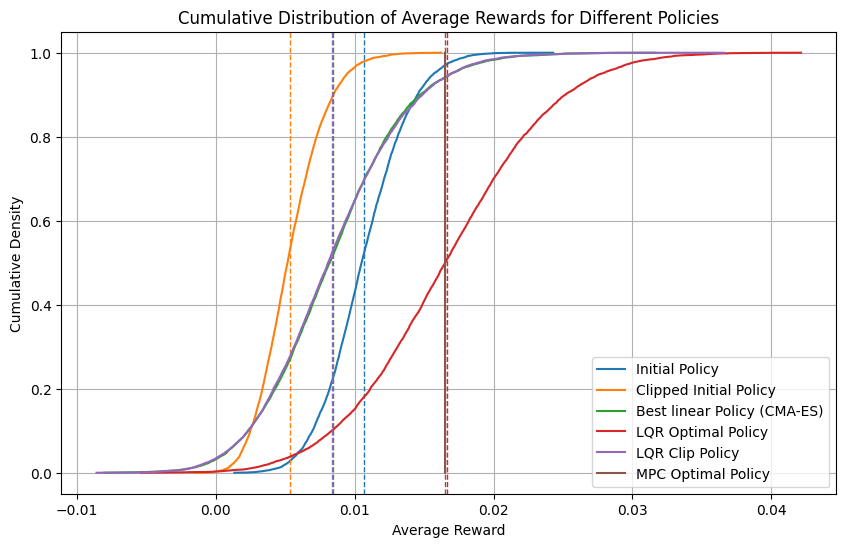

In [ ]:
# run for all 3 policies and store the rewards
n_traj = 10000

print(f"Evaluation of all policies over {n_traj} trajectories ...")
# filter out duplicate policies by name
policy_list = list({name: (func, name) for func, name in policy_list}.values())

all_rewards = np.zeros((len(policy_list), n_traj))
for i in range(len(policy_list)):
    x, u, xi_p = generate_trajectories(policy_list[i][0], x0=(0, 0, 0), T=1000, N=n_traj if "mpc" not in policy_list[i][1].lower() else 1, show_progress=True)
    all_rewards[i] = np.nanmean(reward(x, u, xi_p, 1000), axis=0).T
    print(f"{policy_list[i][1]:30s}  Average reward = {np.nanmean(all_rewards[i]):.8f} , Std = {np.std(all_rewards[i]):.8f}")


# plot all the rewards
plt.figure(figsize=(10, 6))
labels = [policy_list[i][1] for i in range(len(policy_list))]
plt.hist(all_rewards.T, bins=30, label=labels, alpha=1)
# add the mean of each distribution
for i in range(all_rewards.shape[0]):
    plt.axvline(np.nanmean(all_rewards[i]), color=f'C{i}', linestyle='dashed', linewidth=1)
plt.xlabel('Average Reward')

plt.title('Distribution of Average Rewards for Different Policies')
plt.ylabel('Average Reward')
plt.grid()
plt.legend()
plt.savefig("figures/policy_comparison_histogram.svg", format='svg')


# the integral plot
plt.figure(figsize=(10, 6))
for i in range(all_rewards.shape[0]):
    sorted_rewards = np.sort(all_rewards[i])
    cumulative = np.arange(1, len(sorted_rewards) + 1) / len(sorted_rewards)
    plt.plot(sorted_rewards, cumulative, label=labels[i])
    plt.axvline(np.nanmean(all_rewards[i]), color=f'C{i}', linestyle='dashed', linewidth=1)

plt.xlabel('Average Reward')
plt.title('Cumulative Distribution of Average Rewards for Different Policies')
plt.ylabel('Cumulative Density')
plt.grid()
plt.legend()
plt.savefig("figures/policy_comparison_cumulative_distribution.svg", format='svg')


In [ ]:
plt.show()
